# Libraries to import

In [1]:
from math import sin,sqrt
from numpy import array,arange
from pylab import plot,xlabel,ylabel,show,subplot
import numpy as np

import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib



from math import sqrt,pi,atan,tan,cos
from numpy import array,arange,matrix,transpose,squeeze
from numpy.linalg import inv,norm,det    # inv: matrix inverse, det: determinant
from pylab import plot,xlabel,ylabel,show,legend


# Trajectory of Missile Function Using runge kutta method

In [52]:
def trajectory_missile(u_x,u_y,u_z):

    def f(r,t):
        R = 0.08
        g = 9.8
        p = 1.22
        C = 0.47
        m = 1000

        resist = -0.5*(np.pi * (R**2) * p * C)/m

        a=r[3]
        b=r[4]
        c=r[5]

        fx=a
        fy=b
        fz=c

        v_tot = np.sqrt(a**2 + b**2 + c**2)


        fa= resist* a * v_tot
        fb= resist* b * v_tot
        fc= -g + resist* c * v_tot


        return array([fx,fy,fz,fa,fb,fc],float)



    a = 0.0
    b = 10
    N = 10000
    h = (b-a)/N

    tpoints = arange(a,b,h)
    xpoints = []
    ypoints = []
    zpoints = []
    apoints = []
    bpoints = []
    cpoints = []


    r = array([0,0,0,u_x,u_y,u_z],float)

    for t in tpoints:

        if r[2] < 0 : # height cant be negative 
            break
        xpoints.append(r[0])
        ypoints.append(r[1])
        zpoints.append(r[2])


        apoints.append(r[3])
        bpoints.append(r[4])
        cpoints.append(r[5])

        k1 = h*f(r,t)
        k2 = h*f(r+0.5*k1,t+0.5*h)
        k3 = h*f(r+0.5*k2,t+0.5*h)
        k4 = h*f(r+k3,t+h)
        r += (k1+2*k2+2*k3+k4)/6

    return xpoints,ypoints,zpoints

# Finding trajectory of a plane using simple equations of motion

In [38]:
# Function for inputting plane info. and trajectory

def plane_traj(x,y,z,u_x,u_y,u_z,a_x,a_y,a_z,t):
    global t_trajx
    global t_trajy
    global t_trajz
    t_trajx = []
    t_trajy = []
    t_trajz = []
    
    for t in range(t+1):
        # using motions of equations
        s_x = x + u_x * t + 0.5 * a_x * t**2
        s_y = y + u_y * t + 0.5 * a_y * t**2
        s_z = z + u_z * t + 0.5 * a_z * t**2
        t_trajx.append(s_x)
        t_trajy.append(s_y)
        t_trajz.append(s_z)
    return(s_x,s_y,s_z)

def plane_pos(x,y,z,u_x,u_y,u_z,a_x,a_y,a_z,t):

    # using motions of equations
    s_x = x + u_x * t + 0.5 * a_x * t**2
    s_y = y + u_y * t + 0.5 * a_y * t**2
    s_z = z + u_z * t + 0.5 * a_z * t**2

    return(s_x,s_y,s_z)



# Finding Optimal Trajectory without predefined missile speed limit

In [154]:
def optimal_traj(ti,tf,t_x,t_y,t_z,t_vx,t_vy,t_vz,t_ax,t_ay,t_az):

    Cdrag = 0.47 # coefficient of drag

    # Parameters in SI units
    g = 9.8         # Acceleration due to gravity
    m = 1.          # Mass of the projectile
    R = 0.08        # Radius of the spherical projectile
    rho = 1.22      # Air density
    xi = 0.         # Initial horizontal position
    yi = 0.         # Initial vertical position
    zi = 0


    # Final position of target after t seconds
    xf , yf , zf = plane_traj(t_x,t_y,t_z,t_vx,t_vy,t_vz,t_ax,t_ay,t_az,tf-ti)

    def f(r,t):
        R = 0.08
        g = 9.8
        p = 1.22
        C = 0.47
        m = 1000

        resist = -0.5*(np.pi * (R**2) * p * C)/m


        a=r[1]
        b=r[3]
        c=r[5]

        fx=a
        fy=b
        fz=c

        v_tot = np.sqrt(a**2 + b**2 + c**2)


        fa= resist* a * v_tot
        fb= resist* b * v_tot
        fc= -g + resist* c * v_tot


        return array([fx,fa,fy,fb,fz,fc],float)
    # Function that takes initial velocity [vix,viy] as input and returns
    # discrepancies from the final condition
    # The input and output are both 1D arrays of length 2


    # This is the function of which the root(s) we will find by Newton's method
    def Fnewton(vi):
        N = 1000 						   # Number of steps in shooting
        dt = (tf-ti)/N 					# Timestep size in shooting
        r = array([xi,vi[0],yi,vi[1],zi,vi[2]],float) 		# Set the ICs of the IVP
        tpoints = arange(ti,tf,dt)    
        # Start shooting by fourth-order RK
        for t in tpoints:
            k1 = dt*f(r,t)
            k2 = dt*f(r+0.5*k1,t+0.5*dt)
            k3 = dt*f(r+0.5*k2,t+0.5*dt)
            k4 = dt*f(r+k3,t+dt)
            r += (k1+2*k2+2*k3+k4)/6
        return array([r[0]-xf,r[2]-yf,r[4]-zf],float)


    maxIT = 50 				    # Maximum number of Newton's iteration allowed    
    accuracy = 1.e-6 			 # Desired accuracy on the initial speed or the final position
    ds = 1.e-9                # Step size used in numerical evaluation of derivatives
    deltax = array([ds/2,0.,0.])
    deltay = array([0.,ds/2,0.])
    deltaz = array([0.,0.,ds/2])
    vi = array([100., 100.,100.]) 		# Initial guess
    delta = 1.0 				     # Error estimation of Newton's method, initialized to any number > accuracy
    count = 0 				        # Counter for number of iterations
    while delta>accuracy:

        if count>maxIT:
            exit("Newton's method fails. Bad initial guess, or no solution for the given BC.")
            # No root found after maxIT times of Newton's iterations

        Fvi =  Fnewton(vi)   

        # Partial derivatives
        dFxdx = (Fnewton(vi+deltax)[0]-Fnewton(vi-deltax)[0])/ds
        dFxdy = (Fnewton(vi+deltay)[0]-Fnewton(vi-deltay)[0])/ds
        dFxdz = (Fnewton(vi+deltaz)[0]-Fnewton(vi-deltaz)[0])/ds

        dFydx = (Fnewton(vi+deltax)[1]-Fnewton(vi-deltax)[1])/ds
        dFydy = (Fnewton(vi+deltay)[1]-Fnewton(vi-deltay)[1])/ds
        dFydz = (Fnewton(vi+deltaz)[1]-Fnewton(vi-deltaz)[1])/ds

        dFzdx = (Fnewton(vi+deltax)[2]-Fnewton(vi-deltax)[2])/ds
        dFzdy = (Fnewton(vi+deltay)[2]-Fnewton(vi-deltay)[2])/ds
        dFzdz = (Fnewton(vi+deltaz)[2]-Fnewton(vi-deltaz)[2])/ds

        # Define the derivative matrix
        # Defined as matrix instead of array
        # because matrix multiplication will be performed
        Fprime = matrix([[dFxdx,dFxdy,dFxdz],[dFydx,dFydy,dFydz],[dFzdx,dFzdy,dFzdz]])

        # Check if the derivative is singular
        if det(Fprime)==0:
            exit("Bad initial guess, Newton's method fails.")

        # Change Fvi from row array to column vector to do matrix multiplication
        Fvi = transpose(matrix(Fvi))

        # Matrix multiplcation, returning a column vector deltav
        deltav = inv(Fprime)*Fvi  

        Fvi = squeeze(array(transpose(Fvi))) 		      # Change Fvi from column vector back to row array
        deltav = squeeze(array(transpose(deltav))) 	# Change deltav from column vector to row array

        # Defining error estimation. norm treats a 1D arrary as a vector and returns its magnitude
        #delta = norm(deltav)  # Normal definition of error in Newton's method
        delta = norm(Fvi)  # Use this definition if you care more on hitting the target accurately than finding accurate initial velocity

        vi -= deltav # Newton's iteration formula

        count +=1

    return(vi[0],vi[1],vi[2])


# Finding Optimal trajectory with speed < 200

In [143]:
def optimal_traj_200(t_x,t_y,t_z,t_vx,t_vy,t_vz,t_ax,t_ay,t_az):
    vi = array([200., 200.,200.]) 		# Initial guess
    ti = 0
    tf = 0
    total_v =  np.sqrt(vi[0]**2 + vi[1]**2 + vi[2]**2)
    
    while total_v > 200:
        tf = tf + 1

        Cdrag = 0.47 # coefficient of drag

        # Parameters in SI units

        R = 0.08        # Radius of the spherical projectile
        rho = 1.22      # Air density
        xi = 0.         # Initial horizontal position
        yi = 0.         # Initial vertical position
        zi = 0


        # Final position of target after t seconds
        xf , yf , zf = plane_traj(t_x,t_y,t_z,t_vx,t_vy,t_vz,t_ax,t_ay,t_az,tf-ti)
 
        
        def f(r,t):
            R = 0.08
            g = 9.8
            p = 1.22
            C = 0.47
            m = 1000

            resist = -0.5*(np.pi * (R**2) * p * C)/m


            a=r[1]
            b=r[3]
            c=r[5]

            fx=a
            fy=b
            fz=c

            v_tot = np.sqrt(a**2 + b**2 + c**2)


            fa= resist* a * v_tot
            fb= resist* b * v_tot
            fc= -g + resist* c * v_tot


            return array([fx,fa,fy,fb,fz,fc],float)
        # Function that takes initial velocity [vix,viy] as input and returns
        # discrepancies from the final condition
        # The input and output are both 1D arrays of length 2


        # This is the function of which the root(s) we will find by Newton's method
        def Fnewton(vi):
            N = 1000 						   # Number of steps in shooting
            dt = (tf-ti)/N 					# Timestep size in shooting
            r = array([xi,vi[0],yi,vi[1],zi,vi[2]],float) 		# Set the ICs of the IVP
            tpoints = arange(ti,tf,dt)    
            # Start shooting by fourth-order RK
            for t in tpoints:
                k1 = dt*f(r,t)
                k2 = dt*f(r+0.5*k1,t+0.5*dt)
                k3 = dt*f(r+0.5*k2,t+0.5*dt)
                k4 = dt*f(r+k3,t+dt)
                r += (k1+2*k2+2*k3+k4)/6
            return array([r[0]-xf,r[2]-yf,r[4]-zf],float)


        maxIT = 50 				    # Maximum number of Newton's iteration allowed    
        accuracy = 1.e-6 			 # Desired accuracy on the initial speed or the final position
        ds = 1.e-9                # Step size used in numerical evaluation of derivatives
        deltax = array([ds/2,0.,0.])
        deltay = array([0.,ds/2,0.])
        deltaz = array([0.,0.,ds/2])
        delta = 1.0 				     # Error estimation of Newton's method, initialized to any number > accuracy
        count = 0 				        # Counter for number of iterations
        while delta>accuracy:

            if count>maxIT:
                exit("Newton's method fails. Bad initial guess, or no solution for the given BC.")
                # No root found after maxIT times of Newton's iterations

            Fvi =  Fnewton(vi)   

            # Partial derivatives
            dFxdx = (Fnewton(vi+deltax)[0]-Fnewton(vi-deltax)[0])/ds
            dFxdy = (Fnewton(vi+deltay)[0]-Fnewton(vi-deltay)[0])/ds
            dFxdz = (Fnewton(vi+deltaz)[0]-Fnewton(vi-deltaz)[0])/ds

            dFydx = (Fnewton(vi+deltax)[1]-Fnewton(vi-deltax)[1])/ds
            dFydy = (Fnewton(vi+deltay)[1]-Fnewton(vi-deltay)[1])/ds
            dFydz = (Fnewton(vi+deltaz)[1]-Fnewton(vi-deltaz)[1])/ds

            dFzdx = (Fnewton(vi+deltax)[2]-Fnewton(vi-deltax)[2])/ds
            dFzdy = (Fnewton(vi+deltay)[2]-Fnewton(vi-deltay)[2])/ds
            dFzdz = (Fnewton(vi+deltaz)[2]-Fnewton(vi-deltaz)[2])/ds

            # Define the derivative matrix
            # Defined as matrix instead of array
            # because matrix multiplication will be performed
            Fprime = matrix([[dFxdx,dFxdy,dFxdz],[dFydx,dFydy,dFydz],[dFzdx,dFzdy,dFzdz]])

            # Check if the derivative is singular
            if det(Fprime)==0:
                exit("Bad initial guess, Newton's method fails.")

            # Change Fvi from row array to column vector to do matrix multiplication
            Fvi = transpose(matrix(Fvi))

            # Matrix multiplcation, returning a column vector deltav
            deltav = inv(Fprime)*Fvi  

            Fvi = squeeze(array(transpose(Fvi))) 		      # Change Fvi from column vector back to row array
            deltav = squeeze(array(transpose(deltav))) 	# Change deltav from column vector to row array

            # Defining error estimation. norm treats a 1D arrary as a vector and returns its magnitude
            #delta = norm(deltav)  # Normal definition of error in Newton's method
            delta = norm(Fvi)  # Use this definition if you care more on hitting the target accurately than finding accurate initial velocity

            vi -= deltav # Newton's iteration formula

            count +=1
        total_v =  np.sqrt(vi[0]**2 + vi[1]**2 + vi[2]**2)
        
    
    return(vi[0],vi[1],vi[2],tf)

# Finding Optimal trajectory with speed < 200 and Thrust 25 k N

#### Using formula below , one can break down thrust into x, y and z components knowing the angles relation

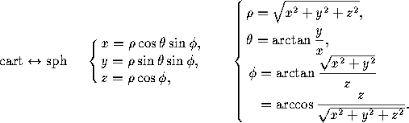

In [ ]:
vi = [200., 200., 200.]
total_thrust = 25000
theta = np.arctan(vi[1]/vi[0])
phi = np.arctan( np.sqrt(vi[1]**2 + vi[0]**2) / vi[2])

thrust_x = total_thrust * np.cos(theta) * np.sin(phi)
thrust_y = total_thrust * np.sin(theta) * np.sin(phi)
thrust_z = total_thrust * np.cos(phi)

In [139]:
def optimal_traj_100_thrust(t_x,t_y,t_z,t_vx,t_vy,t_vz,t_ax,t_ay,t_az):
    vi = array([200., 200.,200.]) # Initial guess
    ti = 0
    tf = 0
    total_v =  np.sqrt(vi[0]**2 + vi[1]**2 + vi[2]**2)
    
    total_thrust = 25000
    
    theta = np.arctan(vi[1]/vi[0])
    phi = np.arctan( np.sqrt(vi[1]**2 + vi[0]**2) / vi[2])

    thrust_x = total_thrust * np.cos(theta) * np.sin(phi)
    thrust_y = total_thrust * np.sin(theta) * np.sin(phi)
    thrust_z = total_thrust * np.cos(phi)

    while total_v > 100:
        tf = tf + 9

        Cdrag = 0.47 # coefficient of drag

        # Parameters in SI units

        R = 0.08        # Radius of the spherical projectile
        rho = 1.22      # Air density
        xi = 0.         # Initial horizontal position
        yi = 0.         # Initial vertical position
        zi = 0
        

        # Final position of target after t seconds
        xf , yf , zf = plane_traj(t_x,t_y,t_z,t_vx,t_vy,t_vz,t_ax,t_ay,t_az,tf-ti)

        def f(r,t):
            R = 0.08
            g = 9.8
            p = 1.22
            C = 0.47
            m = 1000
            
            theta = np.arctan(vi[1]/vi[0])
            phi = np.arctan( np.sqrt(vi[1]**2 + vi[0]**2) / vi[2])

            resist = -0.5*(np.pi * (R**2) * p * C)/m


            a=r[1]
            b=r[3]
            c=r[5]
            
  

            fx=a
            fy=b
            fz=c

            v_tot = np.sqrt(a**2 + b**2 + c**2)


            fa= thrust_x/m + resist* a * v_tot
            fb= thrust_y/m + resist* b * v_tot
            fc= thrust_z/m -g + resist* c * v_tot


            return array([fx,fa,fy,fb,fz,fc],float)
        # Function that takes initial velocity [vix,viy] as input and returns
        # discrepancies from the final condition
        # The input and output are both 1D arrays of length 2


        # This is the function of which the root(s) we will find by Newton's method
        def Fnewton(vi):
            N = 1000 						   # Number of steps in shooting
            dt = (tf-ti)/N 					# Timestep size in shooting
            r = array([xi,vi[0],yi,vi[1],zi,vi[2]],float) 		# Set the ICs of the IVP
            tpoints = arange(ti,tf,dt)    
            thrust_z = total_thrust * np.cos(phi)
            # Start shooting by fourth-order RK
            for t in tpoints:
                k1 = dt*f(r,t)
                k2 = dt*f(r+0.5*k1,t+0.5*dt)
                k3 = dt*f(r+0.5*k2,t+0.5*dt)
                k4 = dt*f(r+k3,t+dt)
                r += (k1+2*k2+2*k3+k4)/6
            return array([r[0]-xf,r[2]-yf,r[4]-zf],float)


        maxIT = 50 				    # Maximum number of Newton's iteration allowed    
        accuracy = 1.e-6 			 # Desired accuracy on the initial speed or the final position
        ds = 1.e-9                # Step size used in numerical evaluation of derivatives
        deltax = array([ds/2,0.,0.])
        deltay = array([0.,ds/2,0.])
        deltaz = array([0.,0.,ds/2])
        delta = 1.0 				     # Error estimation of Newton's method, initialized to any number > accuracy
        count = 0 				        # Counter for number of iterations
        while delta>accuracy:

            if count>maxIT:
                exit("Newton's method fails. Bad initial guess, or no solution for the given BC.")
                # No root found after maxIT times of Newton's iterations

            Fvi =  Fnewton(vi)   

            # Partial derivatives
            dFxdx = (Fnewton(vi+deltax)[0]-Fnewton(vi-deltax)[0])/ds
            dFxdy = (Fnewton(vi+deltay)[0]-Fnewton(vi-deltay)[0])/ds
            dFxdz = (Fnewton(vi+deltaz)[0]-Fnewton(vi-deltaz)[0])/ds

            dFydx = (Fnewton(vi+deltax)[1]-Fnewton(vi-deltax)[1])/ds
            dFydy = (Fnewton(vi+deltay)[1]-Fnewton(vi-deltay)[1])/ds
            dFydz = (Fnewton(vi+deltaz)[1]-Fnewton(vi-deltaz)[1])/ds

            dFzdx = (Fnewton(vi+deltax)[2]-Fnewton(vi-deltax)[2])/ds
            dFzdy = (Fnewton(vi+deltay)[2]-Fnewton(vi-deltay)[2])/ds
            dFzdz = (Fnewton(vi+deltaz)[2]-Fnewton(vi-deltaz)[2])/ds

            # Define the derivative matrix
            # Defined as matrix instead of array
            # because matrix multiplication will be performed
            Fprime = matrix([[dFxdx,dFxdy,dFxdz],[dFydx,dFydy,dFydz],[dFzdx,dFzdy,dFzdz]])

            # Check if the derivative is singular
            if det(Fprime)==0:
                exit("Bad initial guess, Newton's method fails.")

            # Change Fvi from row array to column vector to do matrix multiplication
            Fvi = transpose(matrix(Fvi))

            # Matrix multiplcation, returning a column vector deltav
            deltav = inv(Fprime)*Fvi  

            Fvi = squeeze(array(transpose(Fvi))) 		      # Change Fvi from column vector back to row array
            deltav = squeeze(array(transpose(deltav))) 	# Change deltav from column vector to row array

            # Defining error estimation. norm treats a 1D arrary as a vector and returns its magnitude
            #delta = norm(deltav)  # Normal definition of error in Newton's method
            delta = norm(Fvi)  # Use this definition if you care more on hitting the target accurately than finding accurate initial velocity

            vi -= deltav # Newton's iteration formula
                
            theta = np.arctan(vi[1]/vi[0])
            phi = np.arctan( np.sqrt(vi[1]**2 + vi[0]**2) / vi[2])

            thrust_x = total_thrust * np.cos(theta) * np.sin(phi)
            thrust_y = total_thrust * np.sin(theta) * np.sin(phi)
            thrust_z = total_thrust * np.cos(phi)
            print(vi)

            count +=1
        total_v =  np.sqrt(vi[0]**2 + vi[1]**2 + vi[2]**2)
        print(total_v,vi,tf)
    
    return(vi[0],vi[1],vi[2],tf)

You are located at zero point, the planeis found at (5000,−5000,7000)𝑚, 
its velocity is (−50,50,0)𝑚/𝑠with a acceleration (4,4,4)𝑚/𝑠2

# Trajectory of Missile with Thrust

In [ ]:
def trajectory_thrust_missile(u_x,u_y,u_z,tf): # trajectory of thrusted missile
     
    total_thrust = 25000
    def f(r,t):
        
        R = 0.08
        g = 9.8
        p = 1.22
        C = 0.47
        m = 1000

        
        resist = -0.5*(np.pi * (R**2) * p * C)/m

        a=r[3]
        b=r[4]
        c=r[5]


        theta = np.arctan(r[4]/r[3])
        phi = np.arctan( np.sqrt(r[3]**2 + r[4]**2) / r[5])
        thrust_x = total_thrust * np.cos(theta) * np.sin(phi)
        thrust_y = total_thrust * np.sin(theta) * np.sin(phi)
        thrust_z = total_thrust * np.cos(phi)
  


        fx=a
        fy=b
        fz=c

        v_tot = np.sqrt(a**2 + b**2 + c**2)
                

        fa= resist* a * v_tot + thrust_x/m 
        fb= resist* b * v_tot + thrust_y/m 
        fc= -g + resist* c * v_tot + thrust_z/m 
        


        return array([fx,fy,fz,fa,fb,fc],float)


    a = 0.0
    b = tf
    N = 10000
    h = (b-a)/N

    tpoints = arange(a,b+h,h)
    xpoints = []
    ypoints = []
    zpoints = []
    apoints = []
    bpoints = []
    cpoints = []



    r = array([0,0,0,u_x,u_y,u_z],float)



    for t in tpoints:
        
        if r[2] < 0 : # height cant be negative 
            print(r)
            break
        xpoints.append(r[0])
        ypoints.append(r[1])
        zpoints.append(r[2])

        apoints.append(r[3])
        bpoints.append(r[4])
        cpoints.append(r[5])

        k1 = h*f(r,t)
        k2 = h*f(r+0.5*k1,t+0.5*h)
        k3 = h*f(r+0.5*k2,t+0.5*h)
        k4 = h*f(r+k3,t+h)
        r += (k1+2*k2+2*k3+k4)/6

        


    return r[:3]
